In [ ]:
   !pip install trl gradio accelerate

In [ ]:
!pip install --upgrade wandb

In [ ]:
import transformers
import trl # transformers Reinforcement learning
import datasets
import accelerate
import gradio as gr

In [ ]:
# Check the amount of GPU memory available (we need at least ~16GB)
import torch

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(device)

    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    reserved_memory = torch.cuda.memory_reserved(device)
    free_memory = total_memory - reserved_memory

    print(f"GPU: {gpu_name}")
    print(f"Total Memory:     {total_memory / 1e6:.2f} MB | {total_memory / 1e9:.2f} GB")
    print(f"Allocated Memory: {allocated_memory / 1e6:.2f} MB | {allocated_memory / 1e9:.2f} GB")
    print(f"Reserved Memory:  {reserved_memory / 1e6:.2f} MB | {reserved_memory / 1e9:.2f} GB")
    print(f"Free Memory:      {free_memory / 1e6:.2f} MB | {free_memory / 1e9:.2f} GB")
else:
    print("No CUDA GPU available")

GPU: Tesla T4
Total Memory:     15828.32 MB | 15.83 GB
Allocated Memory: 0.00 MB | 0.00 GB
Reserved Memory:  0.00 MB | 0.00 GB
Free Memory:      15828.32 MB | 15.83 GB


## Setup Base Model

Gemma 3 270M have the same architecture as Gemini but at much smaller scale

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
MODEL_NAME = "google/gemma-3-270m-it" # "it" stands for "instruction tuned" which means the model has been tuned for following instructions

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype='auto',
    device_map="auto", # put model on GPU
    attn_implementation = "eager" # flash_attention_2 could ran into issues
)

Loading weights:   0%|          | 0/236 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"[INFO] Model on device: {model.device}")
print(f"[INFO] Model using dtype: {model.dtype}")

[INFO] Model on device: cuda:0
[INFO] Model using dtype: torch.bfloat16


In [ ]:
tokenizer("Hello my name is Daniel")

{'input_ids': [2, 9259, 1041, 1463, 563, 13108], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
from datasets import load_dataset

dataset = load_dataset("mrdbourke/FoodExtract-1k")

print(len(dataset["train"])) # number of samples

1420


In [ ]:
dataset['train'][0]

{'sequence': 'A mouth-watering photograph captures a delectable dish centered on a rectangular white porcelain plate, resting on a rustic wooden tabletop indoors. In the background, a wooden cutting board with a long handle subtly enhances the setting. The plate is adorned with several generously-sized, cheese-stuffed peppers that have been roasted to perfection, their blistered skins marked by charred black spots. Split down the middle, the peppers reveal a creamy white cheese filling, enriched with a blend of aromatic herbs. Once stuffed, the peppers have been closed and roasted, achieving a luscious, smoky flavor.\n\nThe dish is elegantly garnished with vibrant cherry tomato halves, freshly chopped green herbs, and delicate sprinkles of small diced red onions. A light, possibly citrus-infused dressing, hinted by a sheen of oil or lime juice, gently coats the ensemble, adding an extra layer of freshness. The meticulous presentation and vivid colors make this image not only a feast fo

In [ ]:
import json
import random

def get_random_idx(dataset):
    """Returns a random integer index based on the number of samples in the dataset."""
    random_idx = random.randint(0, len(dataset)-1)
    return random_idx

In [ ]:
random_idx = get_random_idx(dataset["train"])
random_sample = dataset["train"][random_idx]

example_input = random_sample["sequence"]
example_output = random_sample["gpt-oss-120b-label"]
example_output_condensed = random_sample["gpt-oss-120b-label-condensed"]

print(f"[INFO] Input:\n{example_input}")
print()
print(f"[INFO] Example structured output (what we want our model to learn to predict):")
print(eval(example_output))
print()
print(f"[INFO] Example output condensed (we'll train our model to predict the condensed output since it uses less tokens than JSON):")
print(example_output_condensed)



[INFO] Input:
>g^wqS._

[INFO] Example structured output (what we want our model to learn to predict):
{'is_food_or_drink': False, 'tags': [], 'food_items': [], 'drink_items': []}

[INFO] Example output condensed (we'll train our model to predict the condensed output since it uses less tokens than JSON):
food_or_drink: 0
tags: 
foods: 
drinks:


In [ ]:
# Our fine-tuned model will assign tags to text so we can easily filter them by type in the future
tags_dict = {'np': 'nutrition_panel',
 'il': 'ingredient list',
 'me': 'menu',
 're': 'recipe',
 'fi': 'food_items',
 'di': 'drink_items',
 'fa': 'food_advertistment',
 'fp': 'food_packaging'}

## Format the dataset into LLM-style inputs/outputs

The datasdet contains examples of string-based inputs and structured outputs

However our LLM is expecting the following format:

{"user": "Hello my name is Hadi",

"system": "Hi Hadi, I'm an LLM"}

In [ ]:
def sample_to_conversation(sample):
    """Helper function to convert an input sample to conversation style."""
    return {
        "messages": [
            {"role": "user", "content": sample["sequence"]}, # Load the sequence from the dataset
            {"role": "system", "content": sample["gpt-oss-120b-label-condensed"]} # Load the gpt-oss-120b generated label
        ]
    }

sample_to_conversation(random_sample)

{'messages': [{'role': 'user', 'content': '>g^wqS._'},
  {'role': 'system', 'content': 'food_or_drink: 0\ntags: \nfoods: \ndrinks:'}]}

In [ ]:
# Map our sample_to_conversation function to dataset
dataset = dataset.map(sample_to_conversation, batched=False)

dataset["train"][0]

{'sequence': 'A mouth-watering photograph captures a delectable dish centered on a rectangular white porcelain plate, resting on a rustic wooden tabletop indoors. In the background, a wooden cutting board with a long handle subtly enhances the setting. The plate is adorned with several generously-sized, cheese-stuffed peppers that have been roasted to perfection, their blistered skins marked by charred black spots. Split down the middle, the peppers reveal a creamy white cheese filling, enriched with a blend of aromatic herbs. Once stuffed, the peppers have been closed and roasted, achieving a luscious, smoky flavor.\n\nThe dish is elegantly garnished with vibrant cherry tomato halves, freshly chopped green herbs, and delicate sprinkles of small diced red onions. A light, possibly citrus-infused dressing, hinted by a sheen of oil or lime juice, gently coats the ensemble, adding an extra layer of freshness. The meticulous presentation and vivid colors make this image not only a feast fo

In [ ]:
# Create a train/test split

dataset = dataset["train"].train_test_split(test_size = 0.2, shuffle=False, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 1136
    })
    test: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 284
    })
})

## Test the model using pipeline

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe(messages)

In [ ]:
def create_easy_sample(input):
    template = {"role": "user", "content": input}
    return template

In [ ]:

# Load model and use it as a pipeline
#pipe = pipeline("text-generation",
               # model=model,
                #tokenizer=tokenizer)

input_text = "Hi my name is Hadi. Please reply to me with a machine learning poem."
easy_sample = create_easy_sample(input=input_text)
input_prompt = pipe.tokenizer.apply_chat_template([easy_sample], # pipeline tokenizer wants a list of inputs
                                                  tokenize=False,
                                                  add_generation_prompt=True)

print(f"[INFO] This is the input prompt: {input_prompt}")

default_outputs = pipe(input_prompt,
                       max_new_tokens=512,
                       disable_compile=True)

print(f"[INFO] Input:\n{input_text}")
print()
print(f"[INFO] Output from {MODEL_NAME}:")
print()
print(default_outputs[0]["generated_text"][len(input_prompt):])

Passing `generation_config` together with generation-related arguments=({'max_new_tokens', 'disable_compile'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
Both `max_new_tokens` (=512) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] This is the input prompt: <bos><start_of_turn>user
Hi my name is Hadi. Please reply to me with a machine learning poem.<end_of_turn>
<start_of_turn>model

[INFO] Input:
Hi my name is Hadi. Please reply to me with a machine learning poem.

[INFO] Output from google/gemma-3-270m-it:

Hi Hadi,

I'm Hadi. I'm excited to hear from you! Let's write a machine learning poem. I'm looking for a poem that captures the feeling of learning and growth.



## Try the model on one of our sequence

In [ ]:
# Get a random sample
random_idx = get_random_idx(dataset["train"])
random_train_sample = dataset["train"][random_idx]

random_train_sample

{'sequence': 'a victorian christmas christmas',
 'image_url': 'https://i.vimeocdn.com/video/588219797_780x439.jpg',
 'class_label': 'not_food',
 'source': 'qwen2vl_open_dataset',
 'char_len': 31.0,
 'word_count': 4.0,
 'syn_or_real': 'real',
 'uuid': '4d6c2e40-3249-4834-8f3f-93241e183b0c',
 'gpt-oss-120b-label': "{'is_food_or_drink': False, 'tags': [], 'food_items': [], 'drink_items': []}",
 'gpt-oss-120b-label-condensed': 'food_or_drink: 0\ntags: \nfoods: \ndrinks:',
 'target_food_names_to_use': None,
 'caption_detail_level': None,
 'num_foods': None,
 'target_image_point_of_view': None,
 'messages': [{'content': 'a victorian christmas christmas', 'role': 'user'},
  {'content': 'food_or_drink: 0\ntags: \nfoods: \ndrinks:', 'role': 'system'}]}

In [ ]:
random_train_sample["messages"][:1]

[{'content': 'a victorian christmas christmas', 'role': 'user'}]

In [ ]:
# Apply the chat template
input_prompt = pipe.tokenizer.apply_chat_template(conversation=random_train_sample["messages"][:1],
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = pipe(text_inputs=input_prompt, max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

Passing `generation_config` together with generation-related arguments=({'max_new_tokens'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] Input:
<bos><start_of_turn>user
a victorian christmas christmas<end_of_turn>
<start_of_turn>model


[INFO] Output:
The Victorian Christmas is a time of festive cheer, filled with joy, generosity, and a sense of community. It's a time for celebrating the spirit of the season, appreciating the traditions and traditions of the past, and looking forward to the holiday season.



By default the model produces a fairly generic response.

This is expected and good.

It means the model has a good baseline understanding of language.

If it responded with pure garbage, we might have an uphill battle.

However, this response type is not what we want. We want our model to respond with **structured data** based on the input.

## Prompt engineering: few shot learning prompt

In [ ]:
random_idx = get_random_idx(dataset["train"])
random_train_sample = dataset["train"][random_idx]

random_train_sample

{'sequence': '**Screenshot of a Mobile Device Checkout Page - Online Purchase**\n\nThe image is a screenshot from a mobile device featuring the checkout page for an online purchase. At the top of the page, there is a black header with white text that reads "Checkout." Below the header, the majority of the content is displayed on a white background with black font.\n\nThe title of the page, "Delivery Mode," is prominently displayed, separated by a thin line from the details below. The first delivery option is marked by a circular checkbox filled with a brown color, accompanied by the text "Next Business Day (Coffee Orders)." To its right, it indicates that this option is "Free." Beneath this option, there is unbolded text explaining, "Available on coffee-only orders, arrives next business day if placed by 1 p.m. local time."\n\nFollowing the aforementioned delivery mode, additional delivery options are listed:\n\n1. **Standard:** To the right, it says "Free."\n2. **Two Business Days:** 

In [ ]:


prompt_instruction = """Given the following target input text from an image caption, please extract the food and drink items to a list.
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Daniel.
Output:
food_items: []
drink_items: []

Example 2:
Input text: A plate of rice cakes, salmon, cottage cheese and small cherry tomatoes with a cup of tea.
Output:
food_items: ['rice cakes', 'salmon', 'cottage cheese', 'cherry tomatoes']
drink_items: ['cup of tea']

Return only the formatted output and nothing else.

Target input text: <targ_input_text>"""

def update_input_message_content(input):
    original_content = input["messages"][:1][0]["content"]
    new_content = prompt_instruction.replace("<targ_input_text>", original_content)

    new_input = [{"content": new_content,
                  "role": "user"}]

    return new_input

print(f'[INFO] Original content:\n{random_train_sample["messages"][:1][0]["content"]}')
print()
print(f'[INFO] New content with instructions in prompt:')
print(update_input_message_content(input=random_train_sample)[0]["content"])

[INFO] Original content:
**Screenshot of a Mobile Device Checkout Page - Online Purchase**

The image is a screenshot from a mobile device featuring the checkout page for an online purchase. At the top of the page, there is a black header with white text that reads "Checkout." Below the header, the majority of the content is displayed on a white background with black font.

The title of the page, "Delivery Mode," is prominently displayed, separated by a thin line from the details below. The first delivery option is marked by a circular checkbox filled with a brown color, accompanied by the text "Next Business Day (Coffee Orders)." To its right, it indicates that this option is "Free." Beneath this option, there is unbolded text explaining, "Available on coffee-only orders, arrives next business day if placed by 1 p.m. local time."

Following the aforementioned delivery mode, additional delivery options are listed:

1. **Standard:** To the right, it says "Free."
2. **Two Business Days:*

In [ ]:
# Apply the chat template
updated_input_prompt = update_input_message_content(input=random_train_sample)

input_prompt = pipe.tokenizer.apply_chat_template(conversation=updated_input_prompt,
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = pipe(text_inputs=input_prompt,
                       max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] Input:
<bos><start_of_turn>user
Given the following target input text from an image caption, please extract the food and drink items to a list.
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Daniel.
Output:
food_items: []
drink_items: []

Example 2:
Input text: A plate of rice cakes, salmon, cottage cheese and small cherry tomatoes with a cup of tea.
Output:
food_items: ['rice cakes', 'salmon', 'cottage cheese', 'cherry tomatoes']
drink_items: ['cup of tea']

Return only the formatted output and nothing else.

Target input text: **Screenshot of a Mobile Device Checkout Page - Online Purchase**

The image is a screenshot from a mobile device featuring the checkout page for an online purchase. At the top of the page, there is a black header with white text that reads "Checkout." Below the header, the majority of the content is d

It looks like our SLM doesn't do what we really want. It is copying the exact example from the prompt.

We will fine-tune it so it perform the desired task

## Fine-tuning

## Fine-tuning our model

Steps:

1. Setup SFTConfig (Supervised Fine-tuning Config) - https://huggingface.co/docs/trl/v0.26.2/en/sft_trainer#trl.SFTConfig
2. Use SFTTrainer to train our model on our supervised samples (from our dataset above) - https://huggingface.co/docs/trl/v0.26.2/en/sft_trainer#trl.SFTTrainer

In [ ]:
# Setting up our SFTConfig
from trl import SFTConfig

In [ ]:
torch_dtype = model.dtype

CHECKPOINT_DIR_NAME = "/content/drive/MyDrive/Colab Notebooks/SLM fine tunining/checkpoints"
BASE_LEARNING_RATE = 5e-5

print(f"[INFO] Using dtype: {torch_dtype}")
print(f"[INFO] Using learning rate: {BASE_LEARNING_RATE}")

sft_config = SFTConfig(
    output_dir=CHECKPOINT_DIR_NAME,
    max_length=512,
    packing=False,
    num_train_epochs=3,
    per_device_train_batch_size=4, # Reduced from 8 to 4 to save more memory
    per_device_eval_batch_size=4, # Reduced from 8 to 4 to save more memory
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=1,
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=BASE_LEARNING_RATE,
    fp16=True if torch_dtype == torch.float16 else False,
    bf16=True if torch_dtype == torch.float16 else False,
    lr_scheduler_type="constant",
    push_to_hub=False,
    report_to=[]
)


[INFO] Using dtype: torch.bfloat16
[INFO] Using learning rate: 5e-05


In [ ]:
# Supervised Fine-Tuning = provide input and desired output samples
from trl import SFTTrainer

In [ ]:
# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,2.154336,2.233930
2,1.254940,2.281839
3,1.017617,2.462943


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=852, training_loss=1.7503187869776022, metrics={'train_runtime': 1074.3706, 'train_samples_per_second': 3.172, 'train_steps_per_second': 0.793, 'total_flos': 608192361154560.0, 'train_loss': 1.7503187869776022})

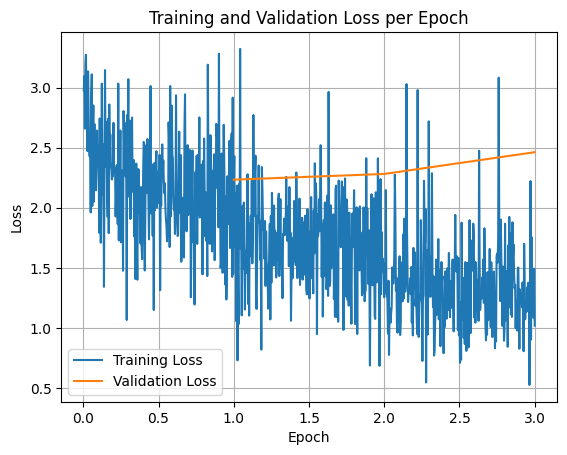

In [ ]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the model
trainer.save_model()

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
CHECKPOINT_DIR_NAME

'/content/drive/MyDrive/Colab Notebooks/SLM fine tunining/checkpoints'

In [ ]:
Model_dir = "/content/drive/MyDrive/Colab Notebooks/SLM fine tunining/checkpoints/checkpoint-852"
# Load the fine-tuned model and see how it goes
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load trained model
loaded_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=Model_dir,
    dtype="auto",
    device_map="auto",
    attn_implementation="eager"
);

Loading weights:   0%|          | 0/236 [00:00<?, ?it/s]

In [ ]:
loaded_model_pipeline = pipeline("text-generation",
                                 model=loaded_model,
                                 tokenizer=tokenizer)

loaded_model_pipeline

TextGenerationPipeline: {'model': 'Gemma3ForCausalLM', 'dtype': 'bfloat16', 'device': 'cuda', 'input_modalities': ('image', 'text'), 'output_modalities': ('text',)}

In [ ]:
dataset["test"]

Dataset({
    features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
    num_rows: 284
})

In [ ]:
# Get a random sample
random_test_idx = get_random_idx(dataset["test"])
random_test_sample = dataset["test"][random_test_idx]

# Apply the chat template
input_prompt = pipe.tokenizer.apply_chat_template(conversation=random_test_sample["messages"][:1],
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = loaded_model_pipeline(text_inputs=input_prompt,
                                        max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

Passing `generation_config` together with generation-related arguments=({'max_new_tokens'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] Input:
<bos><start_of_turn>user
The image shows the back of an orange pouch of Vaalia Probiotics snack. The pouch highlights several key features: 4.5 billion probiotics, 6.9g protein, high calcium, vitamin B12, and low fat. The nutrition information panel lists the average quantity per 100g, including 369 kJ (88 Cal), 4.6g protein, 1.4g fat, 11.4g carbohydrates, 44mg calcium, 0.2mg iron, and 1 billion CFU (colony-forming units) of live yoghurt cultures. The ingredients include milk, milk solids, sugar, water, fruit (6%: mango 3%, banana 3%), skim milk, rice starch, gelatine, natural flavors, lemon juice concentrate, natural color (360a), caramelized sugar, enzyme (lactase), and live yoghurt cultures (from milk) including L. acidophilus, Bifidobacterium, and Lactobacillus (CG). The product contains milk and is marked with the LGG® trademark. A warning states that the cap is not a toy and may present a choking hazard, advising supervision of children while eating. The best before

In [ ]:
print(random_test_sample["gpt-oss-120b-label-condensed"])

food_or_drink: 1
tags: np, il, fi, fp
foods: milk, milk solids, sugar, water, fruit, mango, banana, skim milk, rice starch, gelatine, natural flavors, lemon juice concentrate, natural color (360a), caramelized sugar, enzyme (lactase), live yoghurt cultures, L. acidophilus, Bifidobacterium, Lactobacillus
drinks:


\## Counting the number of parameters in our model

In [ ]:
def get_model_num_params(model):
    """
    Returns the number of trainable, non-trainable and total parameters of a PyTorch model.
    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_params = trainable_params + non_trainable_params
    return {"trainable_params": trainable_params,
            "non_trainable_params": non_trainable_params,
            "total_params": total_params}

# Get parameters of our fine-tuned model
model_params = get_model_num_params(loaded_model)
print(f"Trainable parameters: {model_params['trainable_params']:,}")
print(f"Non-trainable parameters: {model_params['non_trainable_params']:,}")
print(f"Total parameters: {model_params['total_params']:,}")

Trainable parameters: 268,098,176
Non-trainable parameters: 0
Total parameters: 268,098,176


**We've now fine-tuned our own Gemma 3 270M to do a specific task, let's load it back in and see how it performs.\**

Our model is 270M parameters, GPT-OSS-120B is 120B parameters
120_000_000_000 / 270_000_000 = 444.44

:By fine-tuning Gemma 3 270M we distill the capabilities of a 120B parameter model into a model 444x smaller.